### This is my implementation of a convolutional layer and a convolutional neural network. My goal is to replicate the nn.Conv2d layer from Pytorch. The task being learned is to classify the MNIST dataset correctly. 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import math
import pandas as pd
import random
%matplotlib inline

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
g = torch.Generator().manual_seed(47)
random.seed(47)
np.random.seed(47)

In [12]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=True)


In [13]:
class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel: tuple[int] | int, 
        stride: tuple[int] | int, 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> None:
        super().__init__()
        kernel = (kernel, kernel) if type(kernel) is int else kernel
        stride = (stride, stride) if type(stride) is int else stride                                   
        
        k = math.sqrt((1 / (in_channels * kernel[0] * kernel[1]))) # interval for optimal initialization
        
        weight_tensor = torch.randn((out_channels, in_channels * kernel[0] * kernel[1])).uniform_(-k, k)
        self.kernel = nn.Parameter(weight_tensor, requires_grad=True).to(device)
        
        bias_tensor = torch.randn((out_channels,)).uniform_(-k, k)
        self.bias = nn.Parameter(bias_tensor, requires_grad=True).to(device) if bias is True else 0
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
            pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
            x = F.pad(x, (*pad_size_j, *pad_size_i))

        B, C, I, J = x.shape # Batch, Channels, I dim, J dim
        
        # strides
        external_b, external_c, internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = external_b, self.stride_i * internal_i, self.stride_j * internal_j, external_c
        
        # output image dimensions
        out_i = math.floor(((I - self.dilation * (self.kernel_i - 1) - 1) / self.stride_i) + 1)
        out_j = math.floor(((J - self.dilation * (self.kernel_j - 1) - 1) / self.stride_j) + 1)
                
        shape = (B, out_i, out_j, C, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)
        windows = x.as_strided(size=shape, stride=stride).reshape(B, out_i, out_j, C * self.kernel_i * self.kernel_j)
        
        output = ((windows @ self.kernel.T) + self.bias).transpose(1, -1).transpose(2, -1)

        return output
    
    def divide_pad(self, num):
        quotient = num // 2 
        remainder = num % 2 
        return [quotient, quotient + remainder]


In [15]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, fan_in, fan_out, kernel_dim, stride, hidden_dim, output_dim, dilation=1):
        super().__init__()
        self.convo1 = nn.Conv2d(fan_in, fan_out, kernel_dim, stride)
        self.convo2 = nn.Conv2d(fan_out, 5, kernel_dim, stride)
        convo_output_dim = math.floor(((input_dim[0] - dilation * (kernel_dim - 1) - 1) / stride) + 1)
        convo_out2 = math.floor(((convo_output_dim - dilation * (5 - 1) - 1) / stride) + 1)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear1 = nn.Linear(convo_out2**2 * 5, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, y=None, infering=False):
        start = self.convo1(x)
        #print(start.shape)
        x = self.convo2(start)
        #print(x.shape)
        #print(start.shape)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x) * 0.1
        
        if not infering:
            #print(y.shape)
            #print(logits.shape)
            loss = F.cross_entropy(logits, y)
            return logits, loss
        return logits, _


In [16]:
fan_in = 1
fan_out = 32
input_dim = (28,28)
kernel_dim = 5
stride = 1
hidden_dim = 128
n_filters = 16
output_dim = 10

In [17]:
model = ConvNet(input_dim, fan_in, fan_out, kernel_dim, stride, hidden_dim, output_dim = 10)
model = model.to(device);

In [18]:
opt = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_tensor = torch.zeros(len(trainloader))
for i, sample in enumerate(trainloader):
    xb = sample[0].squeeze(0).to(device)
    yb = sample[1].squeeze(0).to(device)
    #print(xb.shape, yb.shape)
    logits, loss = model(xb, yb)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    loss_tensor[i] = loss
    if i == 0:
        print(f'loss {loss.item():.6f}')
        
print('training completed\n')

loss 2.300798
training completed



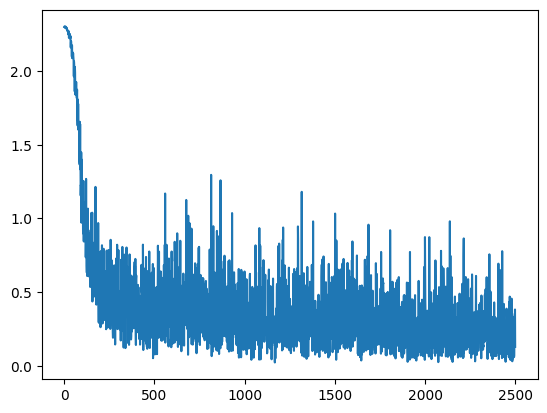

In [108]:
plt.plot(range(len(trainloader)), loss_tensor.tolist()) # >>> nn.Conv2d

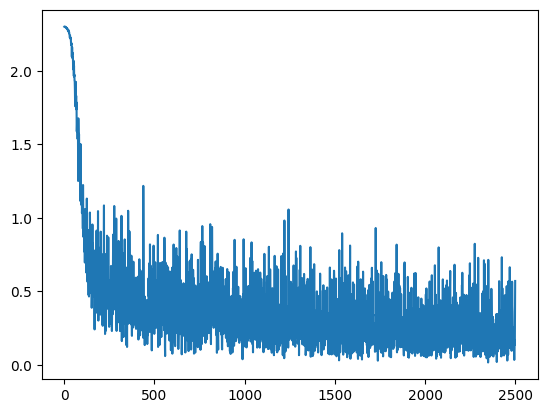

In [103]:
plt.plot(range(len(trainloader)), loss_tensor.tolist()) # >>> my implementation

### From the two graphs above, the first being result of the torch.nn.Conv2d layer and the second being my implementation, it is clear that they are similar. I reached my goal.

In [19]:
@torch.no_grad()
def estimate_loss(eval_iters):
    # estimate the loss. the higher eval_iters is, the more precise the loss will be
    print('estimating loss...')
    model.eval()
    correct = 0
    losses = torch.zeros(eval_iters + 1)
    for i, item in enumerate(testloader):
        if i == eval_iters:
            break
        #print(len(item[0]))
        xb = item[0].squeeze(0).to(device)
        yb = item[1].squeeze(0).to(device)
        logits, loss = model(xb, yb)
        losses[i] = loss.item()
        correct += torch.sum((yb == logits.argmax(1))).item()
            
        
    out = losses.mean().item()
    model.train()
    print(f'precision of {correct/(16*eval_iters)}')
    print(correct, 'correct')
    print(f'estimated loss: {out}\n')

In [20]:
estimate_loss(len(testloader))

estimating loss...
precision of 1.4073741007194245
9390 correct
estimated loss: 0.2092522382736206

